<a href="https://colab.research.google.com/github/doeungim/ADP_DE2/blob/main/ADP_29.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
#!sudo apt-get install -y fonts-nanum

#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

#import matplotlib.pyplot as plt
#plt.rc('font', family='NanumBarunGothic')

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

import pandas as pd
pd.set_option('display.max_columns',200)

#sample etc.
import numpy as np

# vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

#pca
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#t-test
from scipy.stats import ttest_ind


#modeling
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier , DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error , r2_score , f1_score
from sklearn.linear_model import LinearRegression , LogisticRegression

import warnings
warnings.filterwarnings('ignore')


from imblearn.over_sampling import SMOTE
import xgboost as xgb
import scipy.stats as stats
import math
from scipy.stats import chi2_contingency, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import matplotlib.pyplot as plt


In [3]:
df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p1.csv',encoding= 'utf-8')


###### ✅ 1-1 계약자고유번호를 기준으로 거주연도 별 여러개의 데이터가 쌓여 있다. 각 계약자고유번호에 대해 가장 최신의 거주연도 행만 남겨라

In [4]:
# 거주 연도
year_map = df.groupby('계약자고유번호')['거주연도'].max().to_dict()

# Mapping 계약자 고유번호 기준으로 map하여 각 고유번호별 최신 데이터를 나타내는 컬럼 추가
df['new_year'] = df['계약자고유번호'].map(year_map)

# 최신데이터와 같은 거주 연도 필터링
df = df[df['거주연도'] == df['new_year']]

# 계약자고유번호 중복행 제거
df1 = df.sort_values(['계약자고유번호','거주연도']).drop_duplicates(['계약자고유번호'], keep = 'last').reset_index()


# Simple Code
# df.sort_values(['계약자고유번호','거주연도']).drop_duplicates('계약자고유번호',keep='last').reset_index(drop=True)

###### ✅ 1.2 결측치처리

In [5]:
# 계약구분, 아파트 평점, 퇴거연도
print(df1.isna().sum().to_frame().T)

# 계약구분 : 퇴거여부 (퇴거/미퇴거 구분) - 퇴거이면 계약구분 해지 / 미퇴거이면 유효로 적용
df1['계약구분'] =  df1.apply(lambda x : '해지' if x['퇴거여부'] == '퇴거' else '유효' , axis = 1)


# 아파트 평점 - 아파트이름별 아파트 평점 딕셔너리로 결측치 채우기
apart_score = df1.groupby('아파트 이름')['아파트 평점'].mean().to_dict()
df1['아파트 평점'] = df1['아파트 평점'].fillna(df1['아파트 이름'].map(apart_score)) #아파트 이름 map 대상

# 퇴거연도
df1[df1['퇴거연도'].isna()]['퇴거여부'].value_counts() # 미퇴거 상태 >> 불필요한 컬럼으로 삭제


df2 = df1.drop(columns = ['index','순번', '퇴거연도', 'new_year', '아파트 이름'])

print("""
결측치는 계약 구분, 아파트 평점, 퇴거연도에 있으며, 다음과 같이 결측치를 처리한다
1) 계약 구분 : 퇴거여부에 따라 퇴거이면 계약구분 해지 / 미퇴거이면 유효로 적용
2) 아파트 평점 : 아파트이름별 아파트 평점 딕셔너리로 결측치 채우기
3) 퇴거연도 : 결측의 데이터가 미퇴거 상태, 유효한 상태이기 때문에 기록이 안되는 것이 논리적으로 맞다고 판단, 컬럼을 삭제한다.

결측 처리후, 불필요하다고 생각되는 컬럼들을 삭제하여 df2로 저장한다.
""")



   index  순번  계약구분  재계약횟수  거주개월  아파트 이름  아파트 ID  아파트 평점  호실고유번호  층  평형대  \
0      0   0    61      0     0       0       0     141       0  0    0   

   계약자고유번호  계약서고유번호  입주연도  퇴거연도  거주연도  월세(원)  보증금(원)  대표나이  나이  성별  결혼여부  \
0        0        0     0  6257     0      0       0     0   0   0     0   

   거주자 수  퇴거여부  new_year  
0      0     0         0  

결측치는 계약 구분, 아파트 평점, 퇴거연도에 있으며, 다음과 같이 결측치를 처리한다
1) 계약 구분 : 퇴거여부에 따라 퇴거이면 계약구분 해지 / 미퇴거이면 유효로 적용
2) 아파트 평점 : 아파트이름별 아파트 평점 딕셔너리로 결측치 채우기
3) 퇴거연도 : 결측의 데이터가 미퇴거 상태, 유효한 상태이기 때문에 기록이 안되는 것이 논리적으로 맞다고 판단, 컬럼을 삭제한다.

결측 처리후, 불필요하다고 생각되는 컬럼들을 삭제하여 df2로 저장한다.



###### ✅ 1.3 이상치 처리

,재계약횟수,거주개월,아파트 ID,아파트 평점,호실고유번호,층,평형대,계약자고유번호,계약서고유번호,입주연도,거주연도,월세(원),보증금(원),대표나이,나이,거주자 수
count,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,10348.000000,1.034800e+04,10348.000000,10348.000000,10348.000000
mean,5.873695,137.773579,1.809432,6.363645,42980.835330,7.861229,13.220236,48508.618187,46320.571415,2007.092482,2017.752319,63941.468883,3.807054e+06,65.874758,62.627078,1.688152
std,3.215195,77.544927,0.866580,1.284676,25016.449224,4.284426,2.338369,26845.947221,26014.408368,6.224812,3.639131,40259.713978,3.087981e+06,13.787216,14.179781,0.985380
min,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,12.000000,1.000000,1.000000,1994.000000,2008.000000,31300.000000,1.520000e+06,21.000000,20.000000,1.000000
25%,3.000000,71.000000,1.000000,5.000000,21277.750000,4.000000,12.000000,25058.750000,23252.000000,2002.000000,2016.000000,42300.000000,2.052000e+06,57.000000,54.000000,1.000000
50%,6.000000,137.000000,2.000000,7.000000,42946.000000,8.000000,12.000000,48593.500000,48036.500000,2004.000000,2020.000000,44700.000000,2.304000e+06,65.000000,63.000000,1.000000
75%,9.000000,222.000000,2.000000,7.000000,64589.500000,12.000000,12.000000,74050.250000,69061.250000,2012.000000,2020.000000,66700.000000,3.943000e+06,75.000000,73.000000,2.000000
max,12.000000,323.000000,5.000000,10.000000,86891.000000,15.000000,19.000000,86892.000000,86904.000000,2020.000000,2020.000000,311080.000000,2.078400e+07,121.000000,120.000000,10.000000


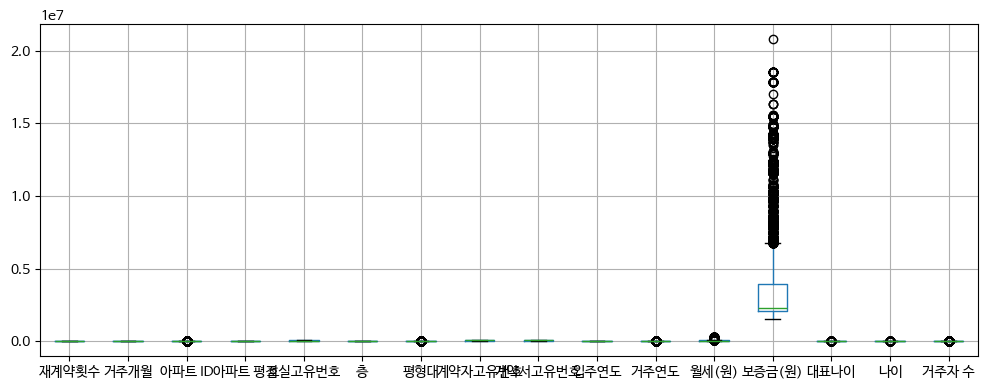


대표나이는 75%와 최대 수치 121로 나이에 이상치가 있는것으로 보여진다.  90세 이상의 데이터는 90으로 맞춘다.
보증금 박스 플롯에서 이상치가 많은 것으로 나타나지만, 아파트 계약에 따른 보증금의 범위가 다양하다는 점을 고려하여, 이상치로 보지 않는다.



In [6]:
# 1) 수치형 변수들의 통계량 확인
display(df2[df2.select_dtypes(exclude = 'object').columns].describe())

numeric_df = df2[df2.select_dtypes(exclude = 'object').columns]
plt.figure(figsize = (10, 4))

numeric_df.boxplot()
plt.tight_layout()
plt.show()

print("""
대표나이는 75%와 최대 수치 121로 나이에 이상치가 있는것으로 보여진다.  90세 이상의 데이터는 90으로 맞춘다.
보증금 박스 플롯에서 이상치가 많은 것으로 나타나지만, 아파트 계약에 따른 보증금의 범위가 다양하다는 점을 고려하여, 이상치로 보지 않는다.
""")

# 2) 나이 데이터 처리
df2['나이'] = df2.apply(lambda x  : 90 if x['나이'] >= 90 else x['나이'], axis = 1)
df2['대표나이'] = df2.apply(lambda x  : 90 if x['대표나이'] >= 90 else x['대표나이'], axis = 1)

# 이상치 처리 후의 df3
df3 = df2.copy()
#display(df3[df3.select_dtypes(exclude = 'object').columns].describe()) #처리 확인

###### ✅ 2.1 재계약 횟수의 중앙값을 기준으로 중앙값보다 크거나 같으면 '높음', 작으면 '낮음' 으로 재계약 횟수 이분 변수를 구성

In [7]:
# df3
m = df3['재계약횟수'].median()
df3['재계약_이분변수'] = df3['재계약횟수'].apply(lambda x : '높음' if x >= m else '낮음')

###### ✅ 2.2 차원축소의 필요성을 논하고, 필요에 따라 차원을 축소하고 불필요하다면 그 근거

      col1    col2      corr
1    재계약횟수    거주개월  0.961945
5    재계약횟수    입주연도  0.737800
11    거주개월   재계약횟수  0.961945
16    거주개월    입주연도  0.799087
55    입주연도   재계약횟수  0.737800
56    입주연도    거주개월  0.799087
85   월세(원)  보증금(원)  0.982391
95  보증금(원)   월세(원)  0.982391

상관분석을 통해 변수 간 중복성 여부를 판단한다.  상관계수가 0.7이상 가지는 컬럼들의 쌍을 출력해본 결과
동일하거나 유사한 정보를 여러 변수가 반복적으로 포함하고 있다는 점을 말하며, 정보의 중복성이 높다는 뜻이다.
수치형 변수 중의 일부는 PCA등의 차원 축소를 통해 정보 중복을 제거하고, 핵심 정보만 압축하여 압축할 필요가 있어 보인다.
예를 들어, 월세와 보증금은 하나의 주성분으로 표현해도 전체 정보의 손실이 크지 않을 것으로 판단된다.



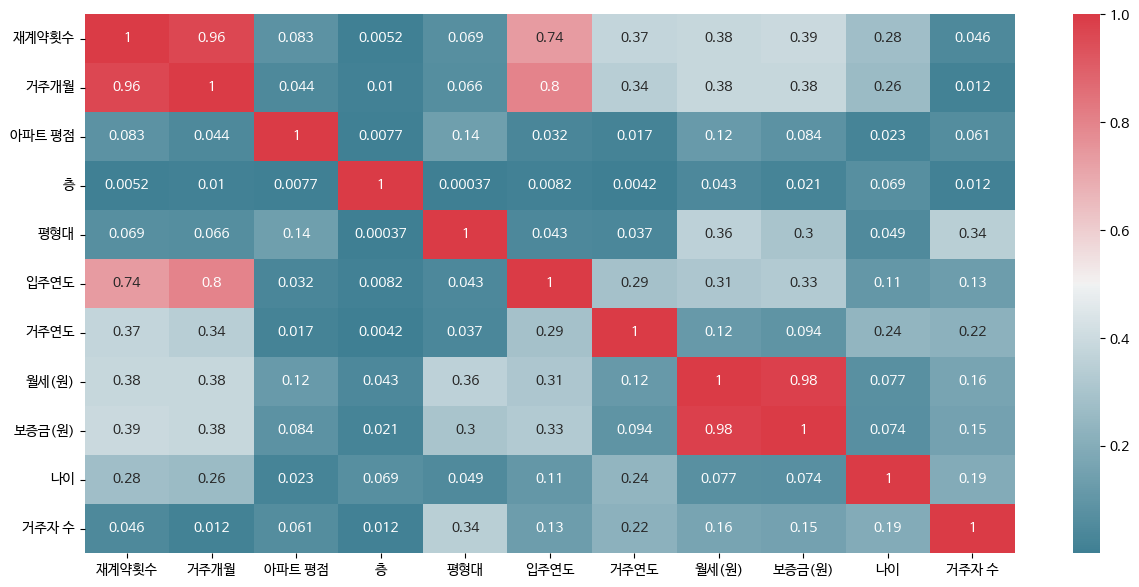

In [8]:
# 차원 축소의 판단 방법
# 1) 상관분석 - 서로 강한 상관관계를 가지는 컬럼들은 정보가 중복된 가능성 - 차원 축소 필요
# 2) 다중공선성 (VIF) - 공선성 문제가 있을 수 있기 때문에 차원 축소 변수 제거 필요
# 같은 원본 수치형 데이터에 대해서 상관분석과 VIF를 병행하여 차원 필요의 중요성을 판단

# 1) 상관분석
# 연속형 수치 변수들의 선형관계를 측정
# 범주형 변수를 포함하고 싶은 경우 전처리(get_dummies) 실행 / 단, 이진화된 경우 상관계수의 해석이 모호해지고, 순서가 없는 범주형
# 변수에 Label Encoding을 쓰면 수치적 관계에 오류 발생

# df4 < 불필요한 컬럼 제거
df4 = df3.drop(columns = ['아파트 ID', '호실고유번호','계약자고유번호','계약서고유번호','대표나이'])


cor_mat = df4[df4.select_dtypes(exclude = 'object').columns].corr().abs()
f, ax = plt.subplots(figsize = (15, 7))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.heatmap(cor_mat, cmap = cmap, annot = True)


# 변수 제거
cor_df = cor_mat.unstack().reset_index().rename(columns = {'level_0':'col1', 'level_1':'col2', 0 : 'corr'})

remove_col = cor_df[(cor_df['col1'] != cor_df['col2']) & (cor_df['corr'] >= 0.7)]
print(remove_col)

print("""
상관분석을 통해 변수 간 중복성 여부를 판단한다.  상관계수가 0.7이상 가지는 컬럼들의 쌍을 출력해본 결과
동일하거나 유사한 정보를 여러 변수가 반복적으로 포함하고 있다는 점을 말하며, 정보의 중복성이 높다는 뜻이다.
수치형 변수 중의 일부는 PCA등의 차원 축소를 통해 정보 중복을 제거하고, 핵심 정보만 압축하여 압축할 필요가 있어 보인다.
예를 들어, 월세와 보증금은 하나의 주성분으로 표현해도 전체 정보의 손실이 크지 않을 것으로 판단된다.
""")

In [9]:
# 2) VIF
numeric_df = df4[df4.select_dtypes(exclude = 'object').columns]

vif = pd.DataFrame()
vif['cols'] = numeric_df.columns

vif['vif'] = [variance_inflation_factor(numeric_df.values, i) for i in range(numeric_df.shape[1])]
vif.sort_values('vif').reset_index(drop = True)

print(vif[vif['vif'] > 10])
print("""
다중 공선성 지표인 VIF > 10 기준으로 컬럼을 조회해본 결과, 입주연도, 거주 연도, 보증금, 월세 등은 서로 유사한 정보를 중복해서
담고 있을 가능성이 크다. 상관계수를 확인했을 때와 마찬가지로 차원 축소가 필요해보인다.
""")

     cols           vif
0   재계약횟수  6.808665e+01
1    거주개월  7.265898e+02
2  아파트 평점  2.797049e+01
4     평형대  4.674858e+01
5    입주연도  1.471390e+07
6    거주연도  1.487124e+07
7   월세(원)  1.307402e+02
8  보증금(원)  8.966750e+01
9      나이  2.400649e+01

다중 공선성 지표인 VIF > 10 기준으로 컬럼을 조회해본 결과, 입주연도, 거주 연도, 보증금, 월세 등은 서로 유사한 정보를 중복해서
담고 있을 가능성이 크다. 상관계수를 확인했을 때와 마찬가지로 차원 축소가 필요해보인다.



,PC_0,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10
ratio,0.314581,0.167678,0.125592,0.094149,0.089340,0.080994,0.070209,0.051675,0.004397,0.001192,0.000192
cumsum,0.314581,0.482260,0.607852,0.702001,0.791341,0.872335,0.942544,0.994219,0.998616,0.999808,1.000000



PCA 분석 결과, 전체 11개의 주성분 중 상위 6개의 주성분만으로 전체 데이터 분산의 약 87%를 설명할 수 있었다.
이는 일반적으로 사용되는 차원 축소 기준(누적 설명력 80~90%)을 만족하므로,
정보 손실 없이 차원을 약 절반으로 축소할 수 있는 근거가 된다.

따라서, 본 데이터는 차원 축소를 통해 변수 수를 줄이되,
핵심 정보는 대부분 유지할 수 있어 차원 축소의 적용이 타당하고 권장된다.




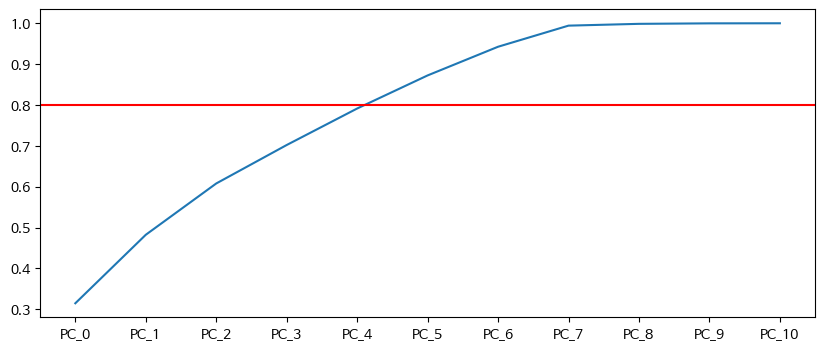

In [10]:
# pca
# 더미화된 0/1 변수는 분산이 작기 때문에 PCA에서 기여도가 매우 낮을 수 있음 > 숫자형만 PCA진행

# PCA를 하기 위해 Scaling 진행 - 평균 0 / 표준편차 1로 정규화
# 스케일링 이유 : 단위의 차이가 커지면, 지나치게 높은 분산을 가지게 됨


scaled_numeric_df = pd.DataFrame(StandardScaler().fit_transform(numeric_df), columns = numeric_df.columns)

pca = PCA()
pca.fit(scaled_numeric_df)

pca_result = pd.DataFrame({
      'ratio' : pca.explained_variance_ratio_,
      'cumsum' : pca.explained_variance_ratio_.cumsum()

  })

pca_result.index = ['PC_' + str(x) for x in range(len(pca_result.index))]

display(pca_result.T)

f, ax = plt.subplots(figsize = (10, 4))
plt.plot(pca_result.index, pca_result['cumsum'])
plt.axhline(0.8, color = 'red')

print("""
PCA 분석 결과, 전체 11개의 주성분 중 상위 6개의 주성분만으로 전체 데이터 분산의 약 87%를 설명할 수 있었다.
이는 일반적으로 사용되는 차원 축소 기준(누적 설명력 80~90%)을 만족하므로,
정보 손실 없이 차원을 약 절반으로 축소할 수 있는 근거가 된다.

따라서, 본 데이터는 차원 축소를 통해 변수 수를 줄이되,
핵심 정보는 대부분 유지할 수 있어 차원 축소의 적용이 타당하고 권장된다.

""")

In [11]:
## 수치형 변수들을 6개로 차원 축소한 데이터 프레임 pca6_df 로 저장
pca = PCA(n_components= 6)
pca6_result = pca.fit_transform(scaled_numeric_df)

pca6_df= pd.DataFrame(pca6_result, columns = ['PC_' + str(x) for x in range(1,7)])


###### ✅ 3-1 재계약 횟수 이분변수를 기준으로 세그먼트를 구분하고 각 세그먼트의 특징을 분석

In [12]:
df5 = df4.drop(columns = ['입주연도','거주연도'])

seg = []
for col in df5.columns[:-1] :
  if df5[col].dtype == 'object' :
    cross_tab = pd.crosstab(df5[col], df5['재계약_이분변수'])
    stat, p_val , dof, expectd = chi2_contingency(cross_tab)

  else :
    g1 = df5[df5['재계약_이분변수'] == '높음'][col]
    g2 = df5[df5['재계약_이분변수'] == '낮음'][col]

    stat, p_val = ttest_ind(g1, g2)

  seg.append([col, p_val])

seg_stat  = pd.DataFrame(seg, columns = ['variable','p_val'])
seg_stat['check'] = seg_stat['p_val'].apply(lambda x : '유의' if x < 0.5 else '유의하지 않음')
display(seg_stat)

print("""
이분 변수의 세그 분석을 위해서 범주형 변수와는 카이제곱 검정을 통해, 독립성을 확인한다.
수치형 변수와는 높음/낮음에 따른 평균 검정을 통해 검정한 결과 월세, 보증금, 나이 등은 두 그룹간 평균 차이가 유의하며,
해당 변수들은 재계약 결과에 영향을 미치는 주요한 요인이라고 해석 될 수 있다.
"층" 변수는 재계약과 유의하지 않은 것으로 보여, 층수에 따른 재계약에 대한 영향력은 미미한 것으로 판단된다.
""")

,variable,p_val,check
0,계약구분,2.316302e-130,유의
1,재계약횟수,0.000000e+00,유의
2,거주개월,0.000000e+00,유의
3,아파트 평점,1.929711e-07,유의
4,층,8.517383e-01,유의하지 않음
5,평형대,1.693525e-09,유의
6,월세(원),5.432890e-286,유의
7,보증금(원),7.951183e-303,유의
8,나이,1.297889e-141,유의
9,성별,8.297464e-16,유의



이분 변수의 세그 분석을 위해서 범주형 변수와는 카이제곱 검정을 통해, 독립성을 확인한다.
수치형 변수와는 높음/낮음에 따른 평균 검정을 통해 검정한 결과 월세, 보증금, 나이 등은 두 그룹간 평균 차이가 유의하며,
해당 변수들은 재계약 결과에 영향을 미치는 주요한 요인이라고 해석 될 수 있다.
"층" 변수는 재계약과 유의하지 않은 것으로 보여, 층수에 따른 재계약에 대한 영향력은 미미한 것으로 판단된다.



###### ✅ 3-2 재계약횟수 변수를 종속변수로 하는 회귀 분석을 두 가지 이상의 방법론을 통해 수행하고 최종 모델을 결정하시오. 재계약횟수 이분변수를 종속변수로 하는 분류 분석을 두가지 이상의 방법론을 통해 수행하고 최종 모델을 결정

In [13]:
numeric_df.head()

# 재계약 횟수 - 회귀분석
y = numeric_df['재계약횟수']

# Numeriic 변수 - scaling
scale_x = pd.DataFrame(StandardScaler().fit_transform(numeric_df.drop(columns =['재계약횟수'])), columns = numeric_df.drop(columns =['재계약횟수']).columns)

#  범주형 준비
dummies_df = pd.get_dummies(df4[df4.select_dtypes(include = 'object').columns[:-1]] , dtype =int)

X = pd.concat([scale_x , dummies_df] , axis = 1)


# Model
rf = RandomForestRegressor()
lr = LinearRegression()

def eval_models(model, name) :
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 31)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  r2 = r2_score(y_test, pred)
  mse = np.sqrt(mean_squared_error(y_test, pred))

  return r2,  mse

result = []
linear_lst = []
for model , name in [[rf ,'RandomForeset'], [lr , 'LinearRegression']] :
  mse, r2 = eval_models(model, name)
  result.append([name, mse, r2])

  linear_lst.append(model)

print(pd.DataFrame(result, columns = ['Model','MSE','R2']))

print("""
'재계약횟수'를 종속변수로 하여 회귀 분석을 수행하였으며,
모델의 예측 성능과 해석 가능성을 종합적으로 고려하기 위해
`선형회귀모델(Linear Regression)`과 `랜덤포레스트 회귀모델(Random Forest Regressor)`의 두 가지 방법론을 비교하였다.

#### 1. Linear Regression
- 가장 기본적이고 직관적인 회귀모델로, 독립변수와 종속변수 간의 선형 관계를 가정한다.
- 변수의 영향력을 계수로 해석할 수 있어 설명력과 해석이 우수하며,
- 다중공선성이나 선형성 가정의 적합 여부를 확인하는 기준점으로 활용할 수 있다.

#### 2. Random Forest Regressor
- 비선형성과 상호작용이 존재할 수 있는 현실적인 데이터의 복잡성을 반영하기 위해,
  **앙상블 기반의 비선형 모델인 랜덤포레스트**를 함께 적용하였다.
- 변수 간 상호작용, 비선형 관계, 이상치에 강인한 특성을 가지고 있어 예측 정확도 측면에서 강력한 성능을 기대할 수 있다.
- 또한, 변수 중요도(feature importance)를 통해 주요 영향 요인을 시각화할 수 있다는 장점이 있다.

이러한 두 모델을 통해, 하나는 해석 중심(Linear Regression), 다른 하나는 **예측 성능 중심(Random Forest)**의 관점에서
분석 결과를 비교하고, 데이터에 적합한 회귀 방법론을 판단하고자 하였다.

""")

              Model       MSE        R2
0     RandomForeset  0.955303  0.674162
1  LinearRegression  0.940966  0.774779

'재계약횟수'를 종속변수로 하여 회귀 분석을 수행하였으며,
모델의 예측 성능과 해석 가능성을 종합적으로 고려하기 위해
`선형회귀모델(Linear Regression)`과 `랜덤포레스트 회귀모델(Random Forest Regressor)`의 두 가지 방법론을 비교하였다.

#### 1. Linear Regression
- 가장 기본적이고 직관적인 회귀모델로, 독립변수와 종속변수 간의 선형 관계를 가정한다.
- 변수의 영향력을 계수로 해석할 수 있어 설명력과 해석이 우수하며,
- 다중공선성이나 선형성 가정의 적합 여부를 확인하는 기준점으로 활용할 수 있다.

#### 2. Random Forest Regressor
- 비선형성과 상호작용이 존재할 수 있는 현실적인 데이터의 복잡성을 반영하기 위해,
  **앙상블 기반의 비선형 모델인 랜덤포레스트**를 함께 적용하였다.
- 변수 간 상호작용, 비선형 관계, 이상치에 강인한 특성을 가지고 있어 예측 정확도 측면에서 강력한 성능을 기대할 수 있다.
- 또한, 변수 중요도(feature importance)를 통해 주요 영향 요인을 시각화할 수 있다는 장점이 있다.

이러한 두 모델을 통해, 하나는 해석 중심(Linear Regression), 다른 하나는 **예측 성능 중심(Random Forest)**의 관점에서
분석 결과를 비교하고, 데이터에 적합한 회귀 방법론을 판단하고자 하였다.




In [14]:
# 재계약횟수 이분변수를 종속변수 - 분류 분석

y = df4['재계약_이분변수'].map({'높음': 1, '낮음' : 0})
X = pd.concat([scaled_numeric_df , dummies_df] , axis = 1)

# Model
rf_cla = RandomForestClassifier(random_state = 42)
lr_cla = LogisticRegression()

def eval_models(model, name) :
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 31)
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  f1 = f1_score(y_test, pred)
  acc = accuracy_score(y_test, pred)

  return r2,  mse

result = []
model_lst = []
for model , name in [[rf_cla ,'RandomForeset'], [lr_cla , 'LogisticRegression']] :
  f1, acc = eval_models(model, name)
  # 모델별 결과
  result.append([name, f1, acc])
  # 사용된 모델을 리스트에 담음 > 변수 중요도 때 끌어다씀
  model_lst.append(model)

print(pd.DataFrame(result, columns = ['Model','F1_score','Accuracy_Score']))
print("""
적합한 두 가지 머신러닝 모델인 `로지스틱 회귀(Logistic Regression)`와 `랜덤포레스트 분류기(Random Forest Classifier)`를 적용하였다.
각 모델은 예측 정확도와 해석 가능성의 균형을 고려하여 선택되었다.

#### 1. Logistic Regression
- 로지스틱 회귀는 범주형 종속변수에 가장 기본적으로 적용되는 선형 모델로,
  예측 결과에 대한 **확률 기반의 해석**이 가능하다는 장점이 있다.
- 또한 모델 계수를 통해 각 독립변수가 재계약 여부에 미치는 영향을 **정량적으로 해석**할 수 있으며,
- 다중공선성이나 변수 간 관계의 단순성을 평가하는 **기준선 모델**로 적합하다.

#### 2. Random Forest Classifier
- 랜덤포레스트는 결정트리를 기반으로 하는 **앙상블 모델로**,
  변수 간 **비선형 관계 및 상호작용을 효과적으로 반영**하여 높은 예측 성능을 보장한다.
- 과적합에 강인하며, 변수 중요도(feature importance)를 통해 주요 영향을 주는 변수들을 파악할 수 있어
  **설명력과 성능을 동시에 추구하는 분석 목적**에 적합하다.
- 특히 범주형 변수와 수치형 변수가 혼합된 구조에서도 성능 저하 없이 유연하게 대응 가능하다.

이러한 두 모델을 적용하여 `F1-score`와 `Accuracy`를 비교함으로써,
하나는 **선형 기반의 해석 가능한 모델(Logistic Regression)**,
다른 하나는 **고성능 비선형 모델(Random Forest)**로서
서로 다른 분석적 관점을 비교하고, 데이터 특성에 가장 적합한 분류 전략을 결정하고자 하였다.

""")

                Model  F1_score  Accuracy_Score
0       RandomForeset  0.774779        0.940966
1  LogisticRegression  0.774779        0.940966

적합한 두 가지 머신러닝 모델인 `로지스틱 회귀(Logistic Regression)`와 `랜덤포레스트 분류기(Random Forest Classifier)`를 적용하였다.
각 모델은 예측 정확도와 해석 가능성의 균형을 고려하여 선택되었다.

#### 1. Logistic Regression
- 로지스틱 회귀는 범주형 종속변수에 가장 기본적으로 적용되는 선형 모델로,
  예측 결과에 대한 **확률 기반의 해석**이 가능하다는 장점이 있다.
- 또한 모델 계수를 통해 각 독립변수가 재계약 여부에 미치는 영향을 **정량적으로 해석**할 수 있으며,
- 다중공선성이나 변수 간 관계의 단순성을 평가하는 **기준선 모델**로 적합하다.

#### 2. Random Forest Classifier
- 랜덤포레스트는 결정트리를 기반으로 하는 **앙상블 모델로**,
  변수 간 **비선형 관계 및 상호작용을 효과적으로 반영**하여 높은 예측 성능을 보장한다.
- 과적합에 강인하며, 변수 중요도(feature importance)를 통해 주요 영향을 주는 변수들을 파악할 수 있어
  **설명력과 성능을 동시에 추구하는 분석 목적**에 적합하다.
- 특히 범주형 변수와 수치형 변수가 혼합된 구조에서도 성능 저하 없이 유연하게 대응 가능하다.

이러한 두 모델을 적용하여 `F1-score`와 `Accuracy`를 비교함으로써,
하나는 **선형 기반의 해석 가능한 모델(Logistic Regression)**,
다른 하나는 **고성능 비선형 모델(Random Forest)**로서
서로 다른 분석적 관점을 비교하고, 데이터 특성에 가장 적합한 분류 전략을 결정하고자 하였다.




###### ✅ 3-3 최종 채택한 모델에서 각각 유의하게 작용하는 변수를 확인 하고 설명

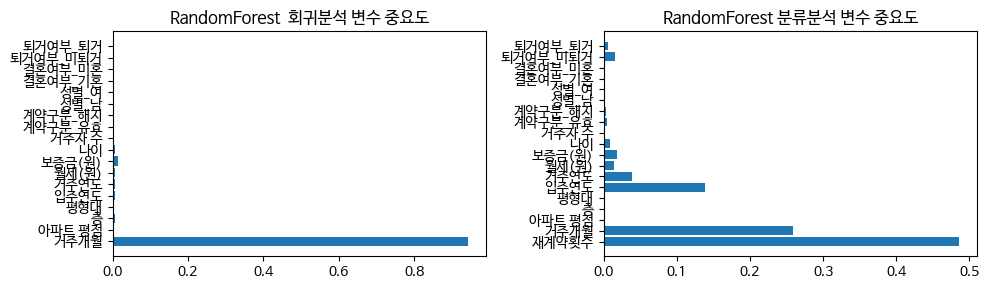

In [15]:
#model_lst[0]
#linear_lst[0]

fig, ax = plt.subplots(1,2, figsize=  (10,3))

# 회귀
ax[0].barh(linear_lst[0].feature_names_in_ , linear_lst[0].feature_importances_)
ax[0].set_title('RandomForest  회귀분석 변수 중요도')
# 분류
ax[1].barh(model_lst[0].feature_names_in_ , model_lst[0].feature_importances_)
ax[1].set_title('RandomForest 분류분석 변수 중요도')

fig.tight_layout()
plt.show()

###### ✅ 4-1 각 회차별로 1번 타자의 출루 (1,2,3루타와 사사구(볼넷, 몸에맞는공))가 있는 경우에 대해 득점이 발생 했는지 확인하고자 한다. 이를 위한 전처리를 수행하라. (단, 첫 번째 혹은 두 번째 타자가 홈런을 친 경우 해당 회차 데이터는 제외한다.)

      1. 첫타자와 둘째타자의 각 이닝별 출루현황, 해당 이닝의 득점수를 3columns의 데이터로 변환
      2. 정수형 값이 아닌 데이터 행를 제거
      3. 홈런 (4)값을 가지는 행을 제거
      4. 이닝별 점수를 binary로 변환 (득점 있으면 1 ,없으면 0 )
      5. 둘째 타자 출루 결과를 one-hot encoding

In [18]:

df =pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p2_.csv')

df.head(3)

,game_id,a1_1,a1_2,a2_1,a2_2,a3_1,a3_2,a4_1,a4_2,a5_1,a5_2,a6_1,a6_2,a7_1,a7_2,a8_1,a8_2,a9_1,a9_2,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,201900016,5,5,5,5,5,5,5,5,5,5,7,1,5,5,1,1,1,5,0,0,0,0,0,0,0,4,2
1,201900023,6,4,5,5,2,5,1,1,6,5,4,1,1,5,5,6,2,7,3,0,0,1,0,1,3,1,0
2,201900103,5,6,5,5,1,9,5,4,6,1,4,2,6,1,5,5,5,6,0,0,1,1,4,1,2,0,1


In [81]:
# 해당 이닝의 득점수를 3columns의 데이터로 변환
lst = []

for i in range(1, 10) :
  x = df[['game_id' ,f'a{i}_1' , f'a{i}_2', f'b{i}' ]]
  x['innings'] = i
  x.columns = ['game_id', 'a_1', 'a_2', 'score', 'innings']
  lst.append(x)

df2 = pd.concat(lst, axis = 0).reset_index(drop = True)

# 정수형 값이 아닌 데이터 행를 제거
df3 = df2[df2['a_1'].apply(lambda x : str(x).isdigit())]


# 3. 홈런 (4)값을 가지는 행을 제거
df4 = df3.loc[(df3['a_1'] != 4)  & (df3['a_2'] != 4)]

#  4. 이닝별 점수를 binary로 변환 (득점 있으면 1 ,없으면 0 )
df4['binary']= df4['score'].apply(lambda x : 1 if x > 0 else 0)

#  5. 둘째 타자 출루 결과를 one-hot encoding
a2_onehot = pd.get_dummies(df4['a_2'], dtype = int)
a2_onehot.columns = [str(i) + '_2nd' for i in a2_onehot.columns]
final_df = pd.concat([df4.drop(columns = ['a_2'], axis =1) , a2_onehot], axis = 1)

final_df.head(3)


,game_id,a_1,score,innings,binary,1_2nd,2_2nd,3_2nd,5_2nd,6_2nd,7_2nd,8_2nd,9_2nd
0,201900016,5,0,1,0,0,0,0,1,0,0,0,0
2,201900103,5,0,1,0,0,0,0,0,1,0,0,0
3,201900112,5,0,1,0,0,0,0,0,0,1,0,0


###### ✅ 4-1 데이터에 대해 Logistic Regression을 적용하고 2번타자의 희생번트 여부에 대한 회귀 계수 검정

In [84]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

X = final_df.drop(columns = ['game_id' , '9_2nd']).astype(int)
y = final_df['9_2nd']


add_x = sm.add_constant(X)
model = sm.Logit(y, add_x)
result = model.fit()
print(result.summary())

print("""
모든 변수들이 p-value 0.99 이상으로 통계적으로 유의하지 않는다. 이러한 문제는
다중공선성, 샘플 불균형 등의 문제가 있을 수도 있다는 점을 나타낸다.
""")

         Current function value: 0.000000
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                  9_2nd   No. Observations:                 1644
Model:                          Logit   Df Residuals:                     1632
Method:                           MLE   Df Model:                           11
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                   1.000
Time:                        06:21:44   Log-Likelihood:            -8.3965e-07
converged:                      False   LL-Null:                       -340.35
Covariance Type:            nonrobust   LLR p-value:                7.405e-139
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.9652   4392.448      0.005      0.996   -8588.075    8630.006
a_1           -0.4399    518.168     -0.001      0.999   -1016.03

###### ✅ 4-3. SMOTE (random_state =0 지정)를 적용하여 data imbalance를 해결하라

In [87]:
from imblearn.over_sampling import SMOTE

sm = SMOTE()
sm_x , sm_y  = sm.fit_resample(X, y)

print(sm_y.value_counts())
print("""
SMOTE 는 오버샘플링의 일종으로, 소수의 클래스를 다수로 복제하는 것으로 데이터 불균형 문제를 해결하는
샘플링 효과이다. 단순히 소수의 클래스를 복제하는 것이 하닌 KNN알고리즘 기반으로 소수의 샘플들 간의
선형 보간법을 사용하여 새로운 샘플을 만든다.
""")

9_2nd
0    1557
1    1557
Name: count, dtype: int64

SMOTE 는 오버샘플링의 일종으로, 소수의 클래스를 다수로 복제하는 것으로 데이터 불균형 문제를 해결하는 
샘플링 효과이다. 단순히 소수의 클래스를 복제하는 것이 하닌 KNN알고리즘 기반으로 소수의 샘플들 간의 
선형 보간법을 사용하여 새로운 샘플을 만든다. 



###### ✅ 4-4 구성 데이터에 Logistic Regression을 적용하고 결과를 [분석](https:// [링크 텍스트](https://))

In [101]:
# 모듈 import
import statsmodels.api as sm                    # sm은 statsmodels 전용으로!
from imblearn.over_sampling import SMOTE        # SMOTE는 smote로 사용


# SMOTE 적용 (smote 객체명 주의!)
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 상수항 추가
X_resampled = sm.add_constant(X_resampled, has_constant=  'add')

# 로지스틱 회귀 모델 적합
model = sm.Logit(y_resampled, X_resampled)
result = model.fit(method = 'bfgs')

# 결과 출력
print(result.summary())
print("""
SMOTE 처리 후로 데이터 클래스간의 불균형 문제를 해소 한 후 모델을 적용한 결과,
처리 전의 결과보다 유의한 변수들이 도출 되었다.
1) innings는 0.032로 이닝이 많을 수록 9번 타자가 2번에 올 확률이 증가하는것으로 나타내며
2) a_1의 첫번쨰 타자는 2번 타순으로 배치될 확률이 낮다 (계수 -1.19)
3) binarny : 희생 번트를 한 경우는 9번타자가 2번에 있을 가능성이 낮다.
""")

         Current function value: 0.015399
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38
                           Logit Regression Results                           
Dep. Variable:                  9_2nd   No. Observations:                 3114
Model:                          Logit   Df Residuals:                     3102
Method:                           MLE   Df Model:                           11
Date:                Sun, 30 Mar 2025   Pseudo R-squ.:                  0.9778
Time:                        06:39:57   Log-Likelihood:                -47.953
converged:                      False   LL-Null:                       -2158.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9100      1.493      6.640      0.000       6.985      12.8

###### ✅ 4-5 구성 데이터에 XGB 적용하고 결과를 분석

0.9967914438502674 0.9409659053435727


<BarContainer object of 12 artists>

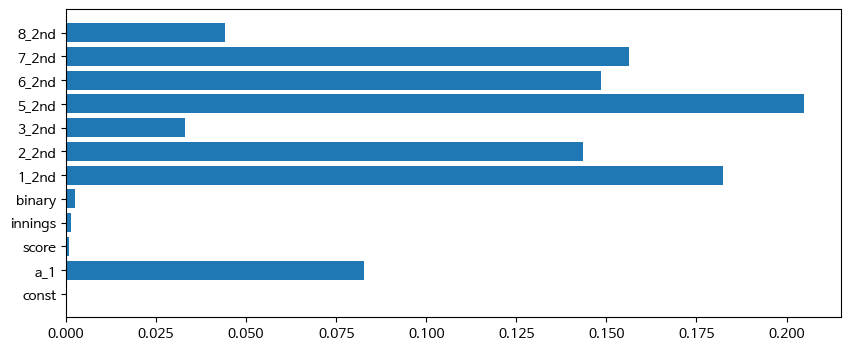

In [110]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score

xgb = XGBClassifier()

x_train, x_test , y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 123)


xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)

f1 = f1_score(y_test, y_pred)
accu = accuracy_score(y_test, y_pred)
print(f1, acc)

plt.figure(figsize = (10, 4))
plt.barh(xgb.feature_names_in_ , xgb.feature_importances_ )

#### 📊 통계분석
###### ✅ 5. 제품 A의 불량률은 0.03이다. 25개의 제품을 뽑았을 때 3개가 불량일 확률

In [113]:
from scipy.stats import binom, norm
p = 0.03
n = 25

rv = binom(n, p)
print(rv.pmf(3))

0.03177384363983214


###### ✅ 6. C사 생산 제품 1000개 중 양품이 600개, D사 생산 제품 500개 중 양품이 200개 이다. 두 회사의 양품률에 차이가 있는지 검정

In [114]:
# 귀무가설 H₀: 두 회사의 양품률은 같다. (p₁ = p₂)
# 대립가설 H₁: 두 회사의 양품률은 다르다. (p₁ ≠ p₂)

# 풀이1)
n1 = 1000
p1 = 600 / 1000

n2 = 500
p2 = 200/ 500

confa = 0.05

# 차이
d = p1 - p2

# 합동분산
pool = (n1*p1 + n2 * p2) / (n1 + n2)
# SE
se = np.sqrt(pool * (1- pool) / n1 +pool * (1- pool) / n2 )

# z_value
z_stat = d / se

# p_value
p_val = 2 * (1 - norm.cdf(abs(z_stat)))
print(p_val)

2.4935609133081016e-13


In [115]:
# 풀이 2) 2-Proportion z-test
from statsmodels.stats.proportion import proportions_ztest

sucess = [600, 200]
nobs = [1000, 500]

stat, p_val = proportions_ztest(sucess, nobs)
print(p_val)

2.493596474326038e-13


###### ✅ 7. 아래 데이터는 a,b,c,d 네 차종 각각 5회 실험 시 범퍼 파손 정도 이다. </br>  (단, 각 모집단은 정규분포를 따르며 모집단 간 등분산성을 가정한다.)

###### ✅ 7-1 . 각 차종 별 범퍼 파손의 정도에 차이가 유의한지 검정

In [134]:
df = pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/29/p7.csv')
df.head()

,name,ratio
0,A,10.993428
1,A,9.723471
2,A,11.295377
3,A,13.046060
4,A,9.531693


In [135]:
from scipy.stats import stats

name = 'name'
var = 'ratio'

anova = stats.f_oneway(*[group[var].values for name, group in df.groupby(name)])
print(anova[0])
print(anova[1])

print("""
귀무가설 : 차종별 범퍼 파손의 정도에 차이가 없다
대립가설 : 차종별 범퍼 파손의 정도에 차이가 있다.
p_value : 2.8174779556216382e-06 < alpha 0.05 귀무가설을 기각함으로, 차종별 범퍼 파손의 정도에 차이가 있다

""")

24.97695307518529
2.8174779556216382e-06

귀무가설 : 차종별 범퍼 파손의 정도에 차이가 없다
대립가설 : 차종별 범퍼 파손의 정도에 차이가 있다. 
p_value : 2.8174779556216382e-06 < alpha 0.05 귀무가설을 기각함으로, 차종별 범퍼 파손의 정도에 차이가 있다




In [139]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd , MultiComparison

df['name'] = df['name'].astype('category')
df['ratio'] = pd.to_numeric(df['ratio'])

# Perform Tukey's HSD post-hoc test
tukey = pairwise_tukeyhsd(df['ratio'], df['name'].cat.codes, alpha = 0.05)
print(tukey)

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1   5.3934  0.001   2.1785  8.6083   True
     0      2  -4.2156 0.0085  -7.4305 -1.0007   True
     0      3  -0.7086 0.9207  -3.9235  2.5063  False
     1      2   -9.609    0.0 -12.8239 -6.3941   True
     1      3   -6.102 0.0003  -9.3169 -2.8871   True
     2      3    3.507 0.0302   0.2921  6.7219   True
-----------------------------------------------------


###### ✅ 7-2  L1,L2,L3 세 개의 생산라인에서 각각 13%, 37%, 50%를 생산하며 각각 1.1% , 2.1%, 3.3% 불량률을 갖는다. 불량 제품이 나왔을 때 L1 라인에서 생산되었을 확률

In [143]:
l1 = 0.13
l2 = 0.37
l3 = 0.5

r1 = 0.011
r2 = 0.021
r3 = 0.033

# 불량품 생산
total_p = l1 * r1 + l2 * r2 + l3 * r3

# L1일 경우
L1_p = (l1 * r1) / total_p
L1_p

0.055642023346303505